In [1]:
# !conda install -c conda-forge librosa

# !conda install tqdm

In [2]:
import torch as ch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as Data

import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

import os
import string
import librosa
import tqdm
import shutil
# !pip install lws
import lws
import IPython.display as ipd
from importlib import reload

import hyperparams
reload(hyperparams)
params = hyperparams.Hyperparams
import datasets
reload(datasets)
import dcttsModel
# from dcttsModel import C,Cs,Css,D,HC,TextEnc,AudioEnc,AudioDec,Text2Mel,SSRN
reload(dcttsModel)
import utils
# from utils import loadChkpt,saveChkpt
reload(utils)

<module 'utils' from '/home/aduriseti/tts/ettts/utils.py'>

In [3]:
dev = ch.device('cuda:0' if ch.cuda.is_available() else 'cpu')
if ch.cuda.is_available():
    ch.multiprocessing.set_start_method("spawn",force=True)

In [4]:
# textEnc = dcttsModel.TextEnc(d=d,e=e,c2i=c2i)
# audioEnc = AudioEnc(d=d,F=F)
# audioDec = AudioDec(d=params.d,F=params.F).to(dev)

ssrn = dcttsModel.SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
text2Mel = dcttsModel.Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)

# print tunable hyperparams
print('HYPERPARAMS',utils.paramDict)
[sum(np.prod(p.size()) for p in m.parameters()) for m in (text2Mel,ssrn)]


HYPERPARAMS {'sep': 3, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'chunk': 1}


[7302008, 8294240]

In [5]:
class DbinLoss(ch.nn.Module):
    def __init__(self):
        super(DbinLoss,self).__init__()
    
    def forward(self,Yhat,Y):
        EPS = 1e-12
        elLoss = -(Y*ch.log(Yhat+EPS)+(1-Y)*ch.log(1-Yhat+EPS))
#         return elLoss.view(elLoss.shape[0],-1).mean(1)
        return elLoss.mean()

class GAttLoss(ch.nn.Module):
    def __init__(self):
        super(GAttLoss,self).__init__()
            
    def forward(self,A):
        _,N,T = A.shape
        W = ch.Tensor([[np.e**(-(n/N-t/T)**2 / (2*params.g**2)) 
                        for t in range(1,T+1)] 
                       for n in range(1,N+1)])
        W = W.to(dev)
        return ((1-W)*A).mean()

L1Fun = ch.nn.L1Loss()
BCEFun = ch.nn.BCELoss()
def MelFun(Shat,S): return L1Fun(Shat,S) + BCEFun(Shat,S)
DbinFun = DbinLoss()
GAttFun = GAttLoss()

In [6]:
import datasets
from importlib import reload
reload(datasets)

nWorkers = 8 if ch.cuda.is_available() else 0
text2MelLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=1),
                                 batch_size=16,
                                 shuffle=True,
                                 num_workers=nWorkers)

text2Mel = dcttsModel.Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)

text2MelOpt = ch.optim.Adam(text2Mel.parameters(),
                          lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 0
if load:
    startEpoch,lossHist,bestLoss = utils.loadChkpt(text2Mel,text2MelOpt,'text2Mel',dev)
else:
    # COLD START - RESET text2Mel
    print('COLD START')
    print('HYPERPARAMS',utils.paramDict)
    text2Mel = dcttsModel.Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)
    text2MelOpt = ch.optim.Adam(text2Mel.parameters(),
                      lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

COLD START
HYPERPARAMS {'sep': 3, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'chunk': 1}


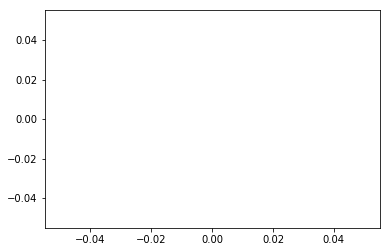

In [7]:
plt.plot(lossHist[0:])

EPOCH 0



epoch 0 total 0.8796013885469579 mel 0.5444797873497009 att 6.443999882321805e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 0, LOSS 0.8796013885469579, BEST LOSS 0.8796013885469579 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


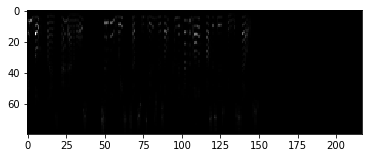

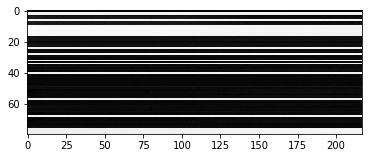

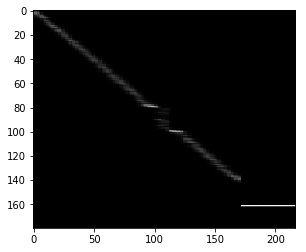

EPOCH 1



epoch 1 total 0.3311707064731797 mel 0.1830519735813141 att 7.285892206709832e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 1, LOSS 0.3311707064731797, BEST LOSS 0.3311707064731797 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


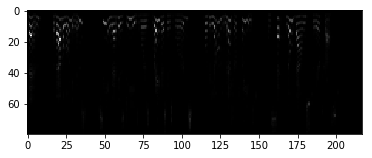

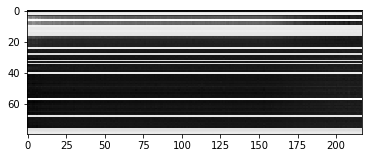

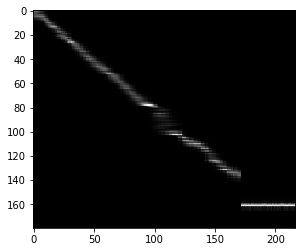

EPOCH 2



epoch 2 total 0.11225724791857733 mel 0.07202975451946259 att 6.355998630169779e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 2, LOSS 0.11225724791857733, BEST LOSS 0.11225724791857733 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


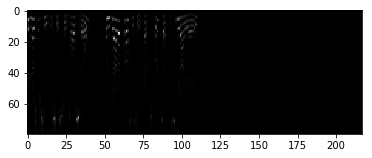

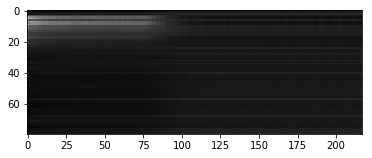

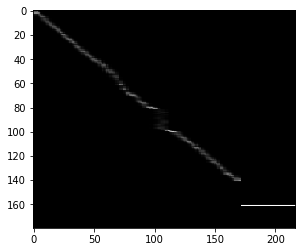

EPOCH 3



epoch 3 total 0.05478020894216068 mel 0.04967056214809418 att 6.431881774915382e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 3, LOSS 0.05478020894216068, BEST LOSS 0.05478020894216068 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


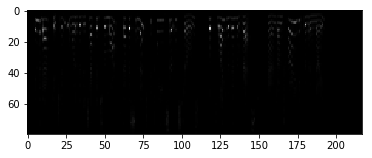

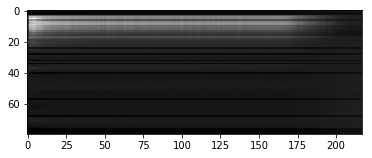

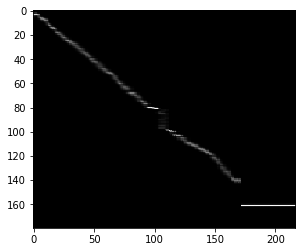

EPOCH 4



epoch 4 total 0.04196888103302735 mel 0.04783957824110985 att 6.17100959061645e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 4, LOSS 0.04196888103302735, BEST LOSS 0.04196888103302735 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


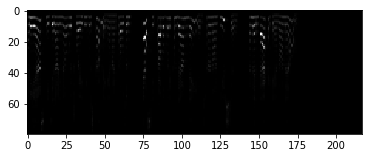

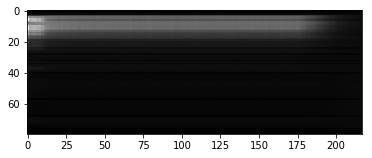

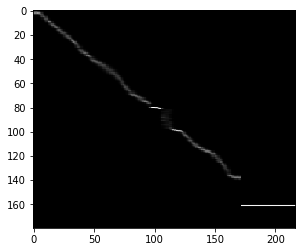

EPOCH 5



epoch 5 total 0.03922774484242076 mel 0.04817667603492737 att 6.0962021962041035e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 5, LOSS 0.03922774484242076, BEST LOSS 0.03922774484242076 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


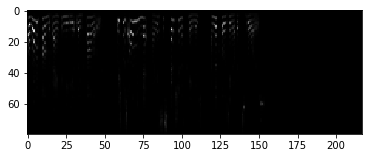

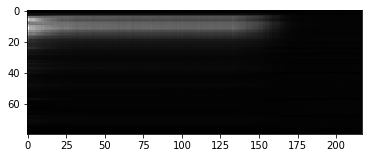

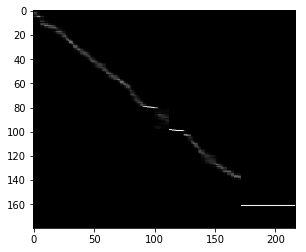

EPOCH 6



epoch 6 total 0.03855357550140192 mel 0.031295761466026306 att 6.155380833661184e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 6, LOSS 0.03855357550140192, BEST LOSS 0.03855357550140192 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


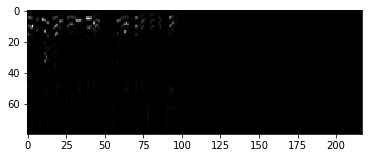

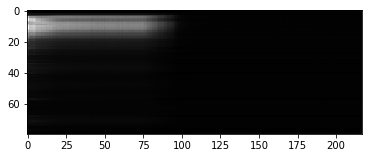

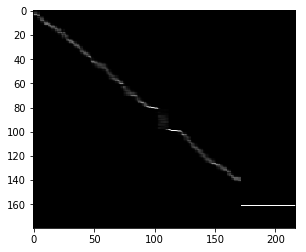

EPOCH 7



epoch 7 total 0.038367313585841833 mel 0.050115812569856644 att 6.033137105987407e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 7, LOSS 0.038367313585841833, BEST LOSS 0.038367313585841833 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


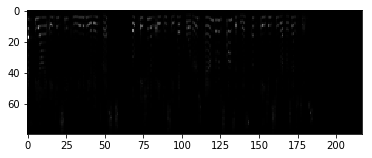

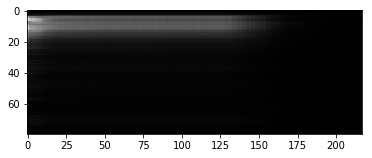

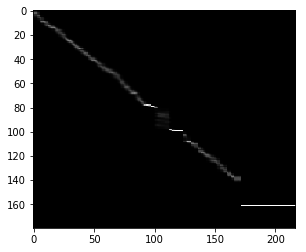

EPOCH 8



epoch 8 total 0.0382166449480982 mel 0.03235569968819618 att 5.960871931165457e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 8, LOSS 0.0382166449480982, BEST LOSS 0.0382166449480982 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


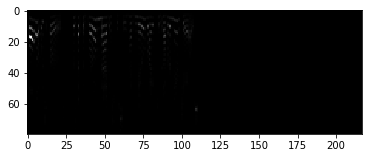

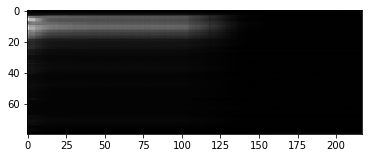

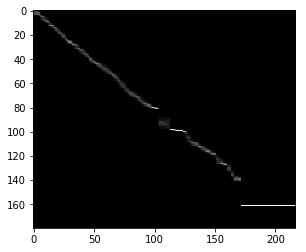

EPOCH 9



epoch 9 total 0.0381954196729322 mel 0.045121125876903534 att 6.0679569287458435e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 9, LOSS 0.0381954196729322, BEST LOSS 0.0381954196729322 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


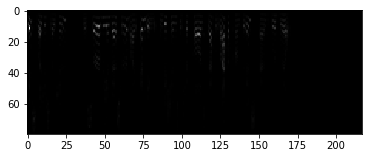

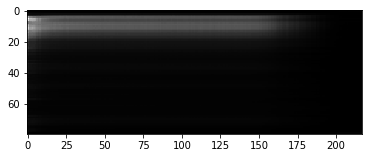

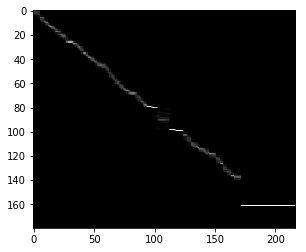

EPOCH 10



epoch 10 total 0.038144118119197996 mel 0.048146020621061325 att 5.893120760447346e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 10, LOSS 0.038144118119197996, BEST LOSS 0.038144118119197996 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


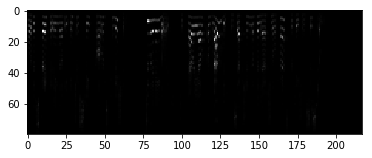

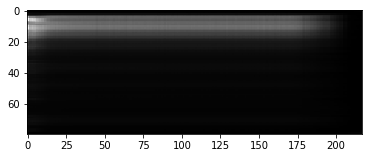

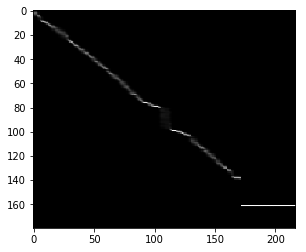

EPOCH 11



epoch 11 total 0.03809353560209274 mel 0.03291217237710953 att 6.009988646837883e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 11, LOSS 0.03809353560209274, BEST LOSS 0.03809353560209274 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


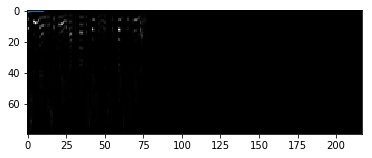

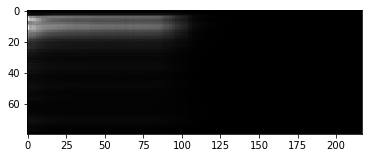

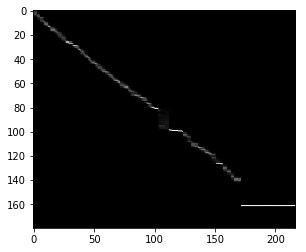

EPOCH 12



epoch 12 total 0.038113256613376424 mel 0.06445351988077164 att 5.8647015976021066e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 12, LOSS 0.038113256613376424, BEST LOSS 0.03809353560209274 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar']


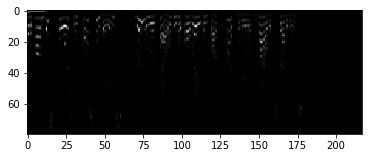

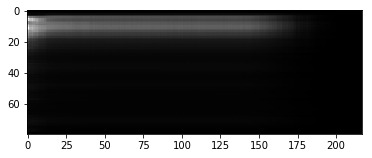

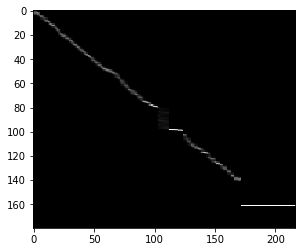

EPOCH 13



epoch 13 total 0.038068366387108366 mel 0.0450933501124382 att 6.005658724461682e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 13, LOSS 0.038068366387108366, BEST LOSS 0.038068366387108366 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


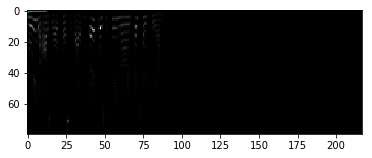

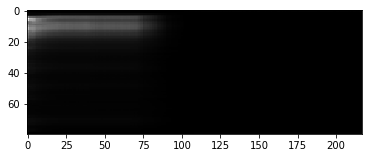

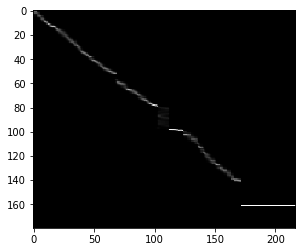

EPOCH 14



epoch 14 total 0.0380734229766166 mel 0.06492935121059418 att 5.986191536067054e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 14, LOSS 0.0380734229766166, BEST LOSS 0.038068366387108366 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar']


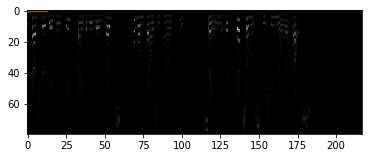

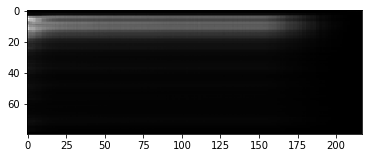

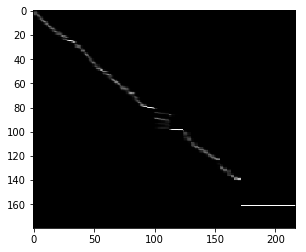

EPOCH 15



epoch 15 total 0.03800587386671287 mel 0.02788635343313217 att 5.865856655873358e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 15, LOSS 0.03800587386671287, BEST LOSS 0.03800587386671287 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


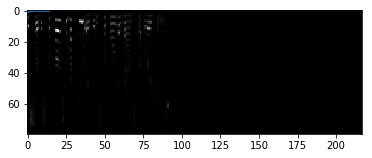

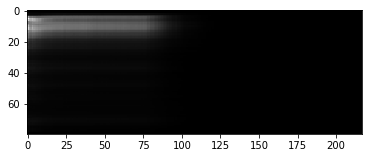

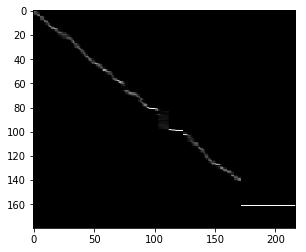

EPOCH 16



epoch 16 total 0.03798941081639991 mel 0.02829880639910698 att 5.9318837884347886e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 16, LOSS 0.03798941081639991, BEST LOSS 0.03798941081639991 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


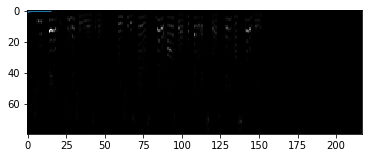

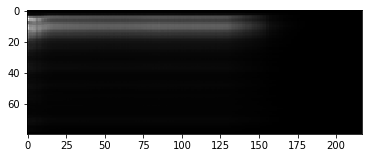

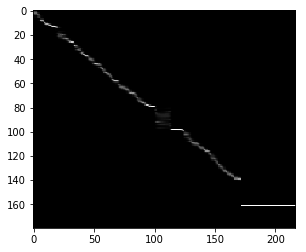

EPOCH 17



epoch 17 total 0.03799509019382409 mel 0.04160008206963539 att 6.050631054677069e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 17, LOSS 0.03799509019382409, BEST LOSS 0.03798941081639991 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar']


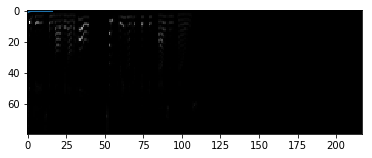

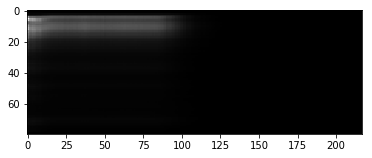

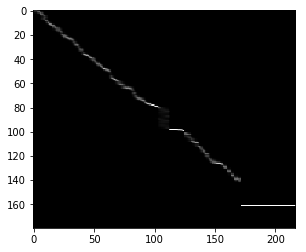

EPOCH 18



epoch 18 total 0.0379743557868164 mel 0.0352800078690052 att 5.991215584799647e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 18, LOSS 0.0379743557868164, BEST LOSS 0.0379743557868164 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


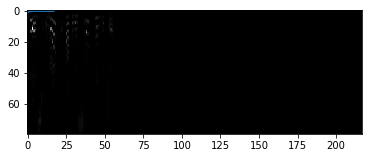

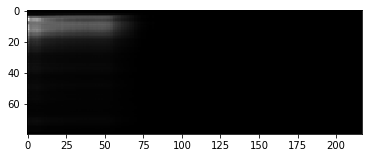

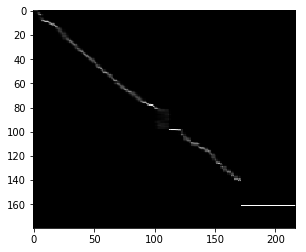

EPOCH 19



epoch 19 total 0.037516278865288445 mel 0.039112240076065063 att 7.340342563111335e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 19, LOSS 0.037516278865288445, BEST LOSS 0.037516278865288445 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


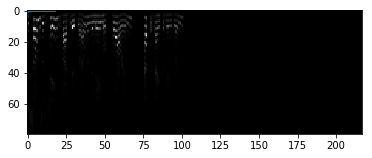

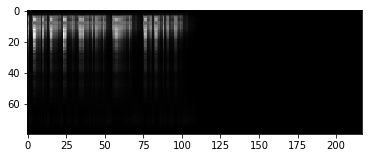

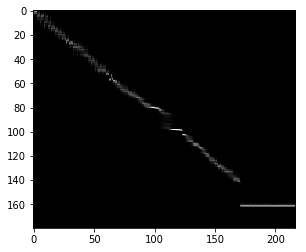

EPOCH 20



epoch 20 total 0.03540203649161467 mel 0.049868643283843994 att 4.9272490286966786e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 20, LOSS 0.03540203649161467, BEST LOSS 0.03540203649161467 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


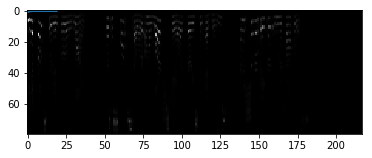

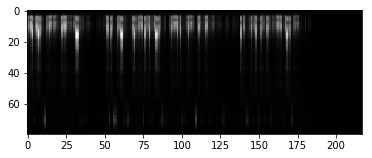

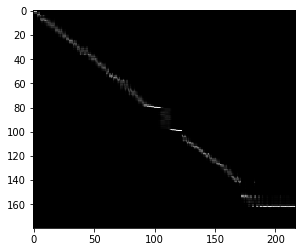

EPOCH 21



epoch 21 total 0.03478476558047444 mel 0.03445305675268173 att 3.862113590002991e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 21, LOSS 0.03478476558047444, BEST LOSS 0.03478476558047444 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


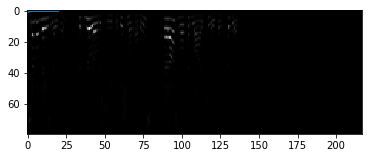

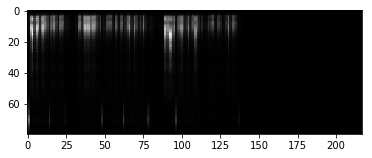

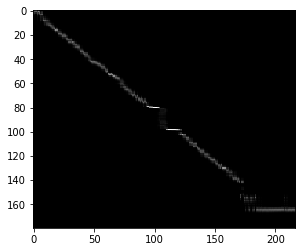

EPOCH 22


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 24 total 0.03357064616379898 mel 0.04547077417373657 att 4.043464286951348e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 24, LOSS 0.03357064616379898, BEST LOSS 0.03357064616379898 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


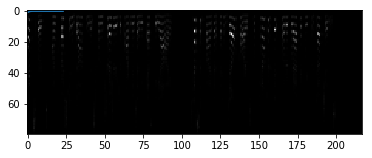

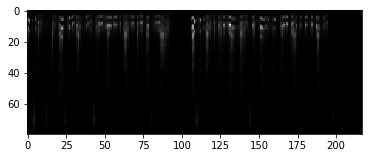

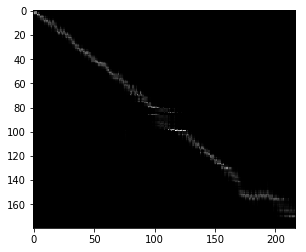

EPOCH 25



epoch 25 total 0.03299917659041152 mel 0.0370062030851841 att 4.7649409680161625e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 25, LOSS 0.03299917659041152, BEST LOSS 0.03299917659041152 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


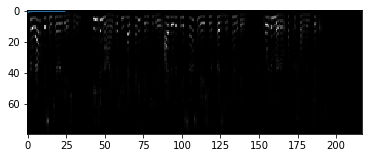

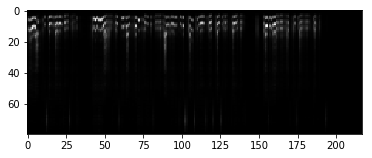

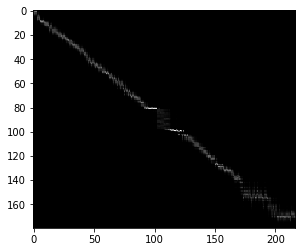

EPOCH 26



epoch 26 total 0.03266327580464865 mel 0.023925669491291046 att 4.478001574170776e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 26, LOSS 0.03266327580464865, BEST LOSS 0.03266327580464865 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


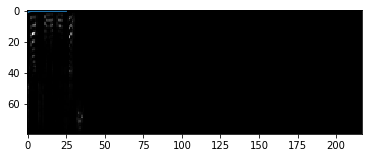

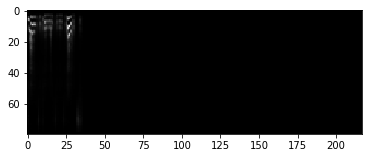

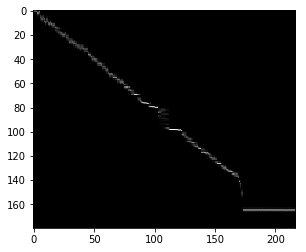

EPOCH 27



epoch 27 total 0.03246486836404943 mel 0.050810184329748154 att 5.4734351579099894e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 27, LOSS 0.03246486836404943, BEST LOSS 0.03246486836404943 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


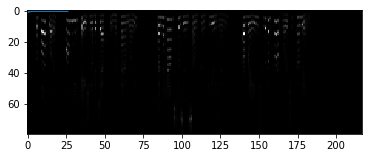

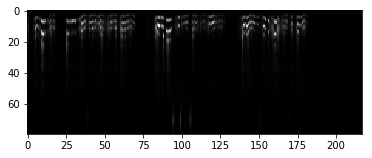

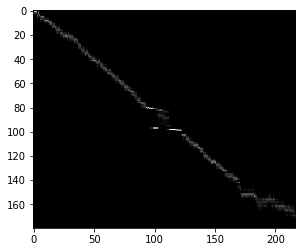

EPOCH 28



epoch 28 total 0.032277039305042866 mel 0.04177785664796829 att 2.457637856423389e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 28, LOSS 0.032277039305042866, BEST LOSS 0.032277039305042866 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


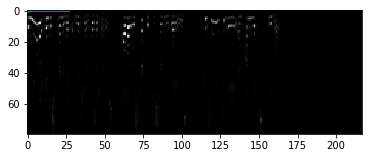

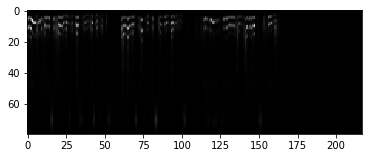

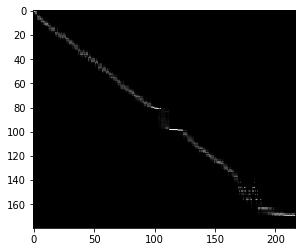

EPOCH 29



epoch 29 total 0.03214969529089198 mel 0.044609662145376205 att 5.6200737162726e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 29, LOSS 0.03214969529089198, BEST LOSS 0.03214969529089198 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


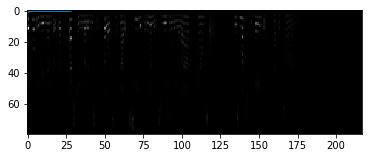

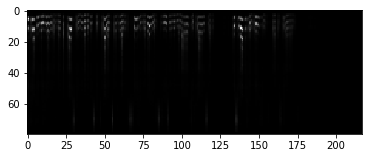

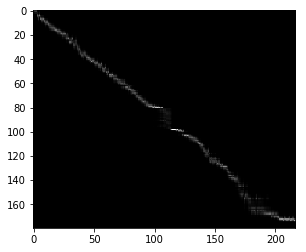

EPOCH 30



epoch 30 total 0.032014487433566975 mel 0.03359859064221382 att 4.741994780488312e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 30, LOSS 0.032014487433566975, BEST LOSS 0.032014487433566975 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


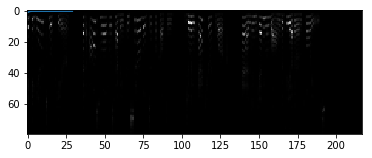

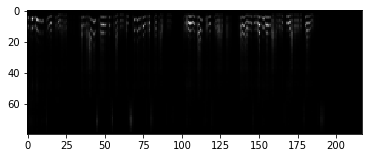

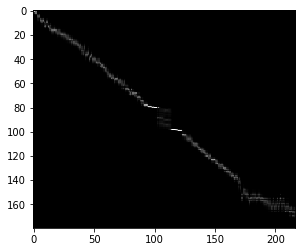

EPOCH 31



epoch 31 total 0.031916672491760396 mel 0.028488092124462128 att 3.022736927960068e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 31, LOSS 0.031916672491760396, BEST LOSS 0.031916672491760396 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


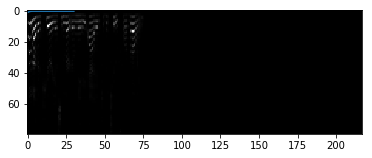

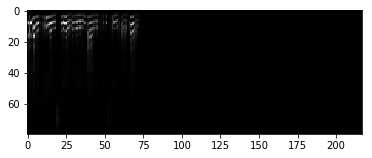

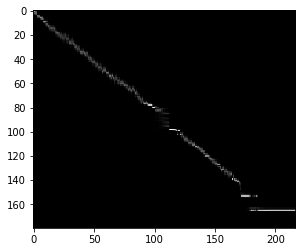

EPOCH 32



epoch 32 total 0.031837247528914196 mel 0.03482202813029289 att 4.4207507016835734e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 32, LOSS 0.031837247528914196, BEST LOSS 0.031837247528914196 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


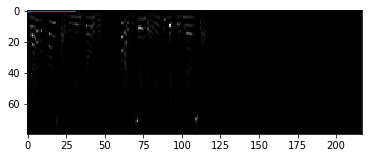

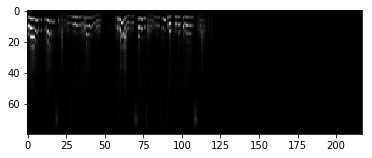

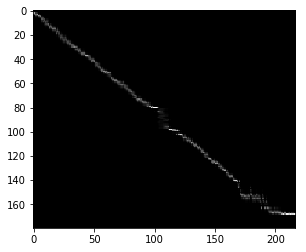

EPOCH 33



epoch 33 total 0.03173877237948464 mel 0.01954323798418045 att 3.1208008294925094e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 33, LOSS 0.03173877237948464, BEST LOSS 0.03173877237948464 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


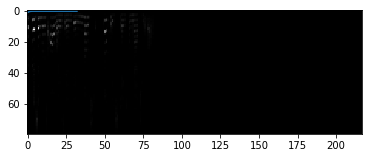

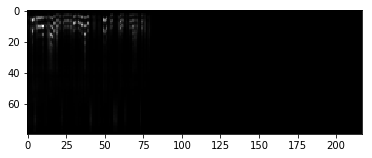

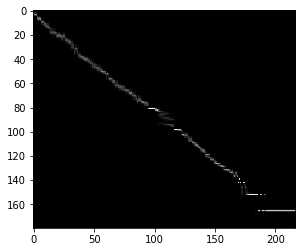

EPOCH 34



epoch 34 total 0.031691388685756654 mel 0.0357799306511879 att 5.105933087179437e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 34, LOSS 0.031691388685756654, BEST LOSS 0.031691388685756654 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


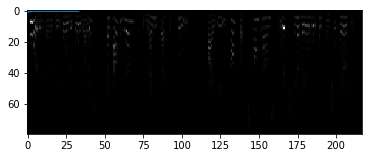

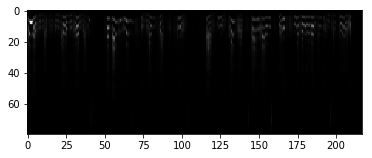

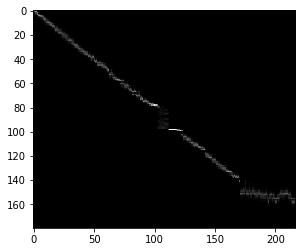

EPOCH 35



epoch 35 total 0.0316231291463126 mel 0.03510011360049248 att 3.392480357433669e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 35, LOSS 0.0316231291463126, BEST LOSS 0.0316231291463126 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


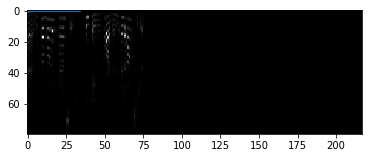

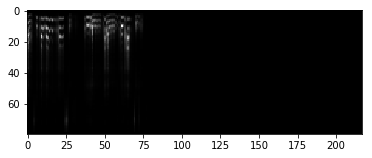

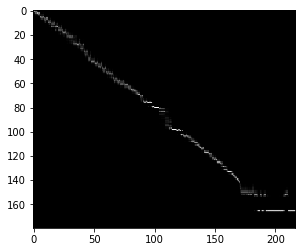

EPOCH 36


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 39 total 0.03134133583073741 mel 0.03539185971021652 att 2.5521965653751977e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 39, LOSS 0.03134133583073741, BEST LOSS 0.03134133583073741 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


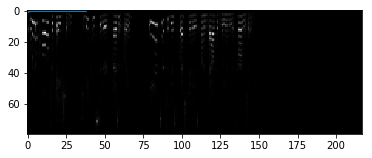

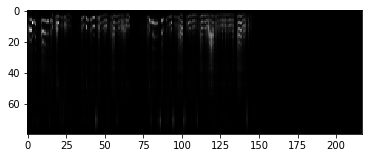

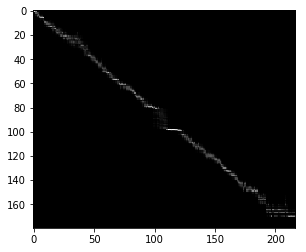

EPOCH 40



epoch 40 total 0.03126663955123122 mel 0.022420838475227356 att 3.52473980456125e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 40, LOSS 0.03126663955123122, BEST LOSS 0.03126663955123122 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


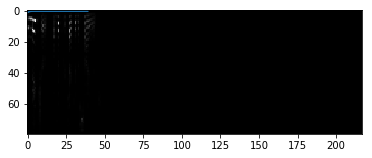

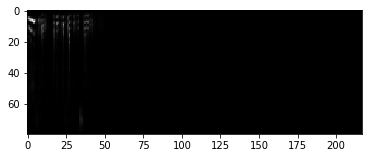

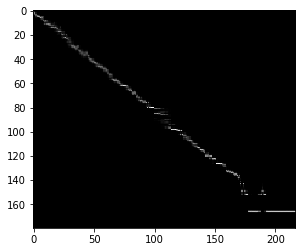

EPOCH 41



epoch 41 total 0.031232243136905913 mel 0.03899755701422691 att 4.649687616620213e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 41, LOSS 0.031232243136905913, BEST LOSS 0.031232243136905913 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


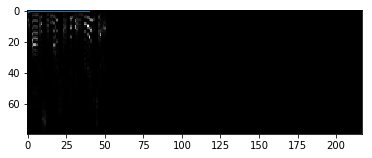

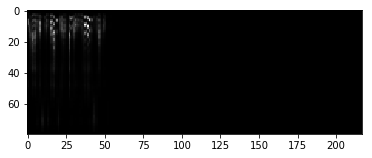

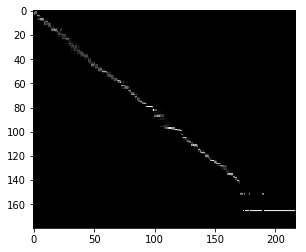

EPOCH 42



epoch 42 total 0.031171286186731574 mel 0.03204001486301422 att 3.239250145270489e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 42, LOSS 0.031171286186731574, BEST LOSS 0.031171286186731574 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


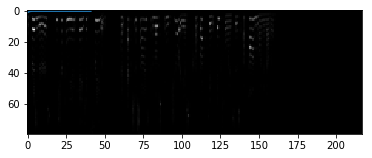

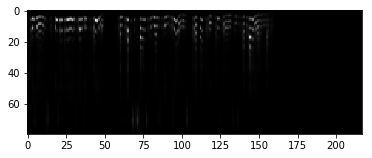

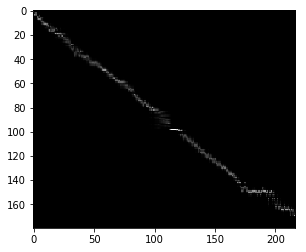

EPOCH 43


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 46 total 0.030976818118300012 mel 0.0350777804851532 att 2.4251530703622848e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 46, LOSS 0.030976818118300012, BEST LOSS 0.030976818118300012 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


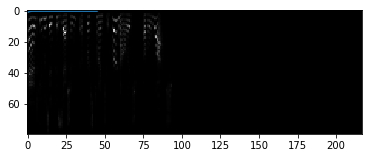

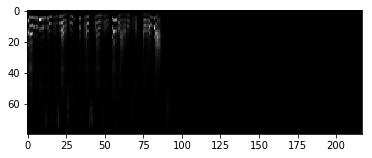

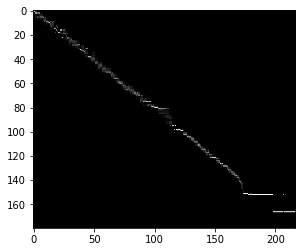

EPOCH 47



epoch 47 total 0.03091721518604613 mel 0.024949487298727036 att 5.584377868217416e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 47, LOSS 0.03091721518604613, BEST LOSS 0.03091721518604613 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


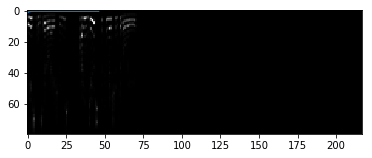

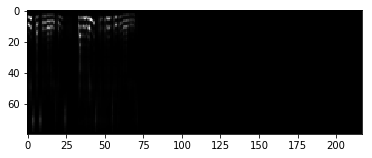

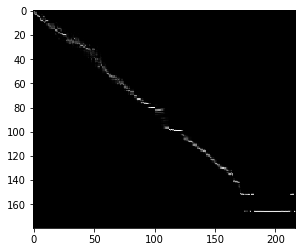

EPOCH 48


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



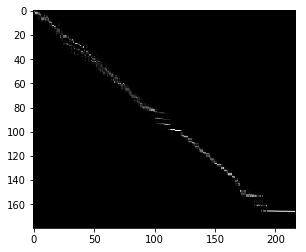

EPOCH 50



epoch 50 total 0.030772343883985902 mel 0.023533407598733902 att 2.968523585877847e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 50, LOSS 0.030772343883985902, BEST LOSS 0.030772343883985902 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


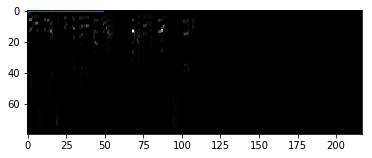

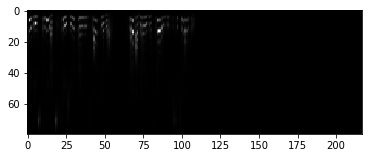

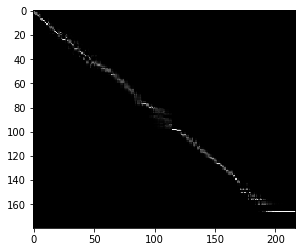

EPOCH 51



epoch 51 total 0.030741255866613852 mel 0.03906625881791115 att 6.0437043430283666e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 51, LOSS 0.030741255866613852, BEST LOSS 0.030741255866613852 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


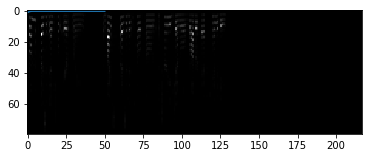

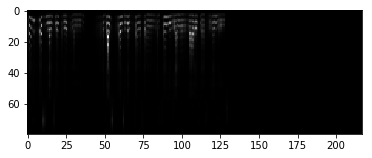

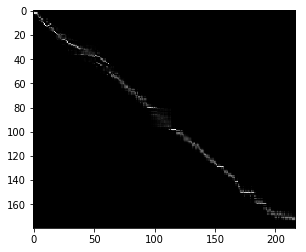

EPOCH 52



epoch 52 total 0.03069391894751965 mel 0.03916408494114876 att 2.6244957552989945e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 52, LOSS 0.03069391894751965, BEST LOSS 0.03069391894751965 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


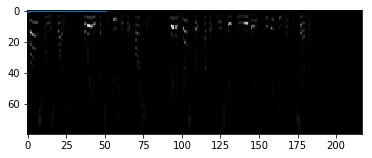

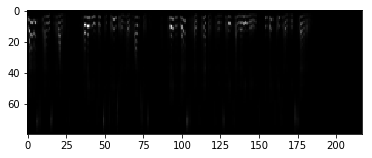

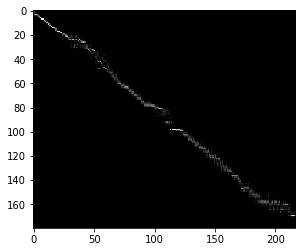

EPOCH 53



epoch 53 total 0.030636355925851795 mel 0.03532252088189125 att 4.4629749027080834e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 53, LOSS 0.030636355925851795, BEST LOSS 0.030636355925851795 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


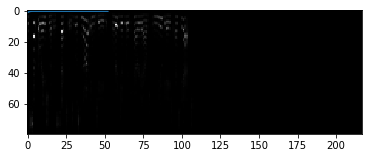

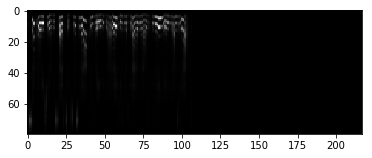

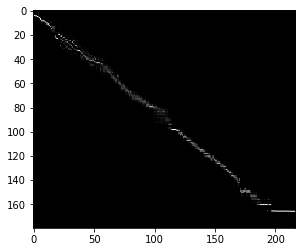

EPOCH 54


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 57 total 0.030375847351084003 mel 0.010548273101449013 att 4.7370347601827234e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 57, LOSS 0.030375847351084003, BEST LOSS 0.030375847351084003 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


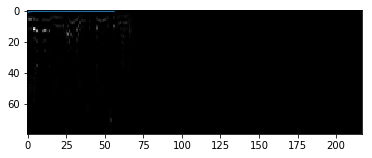

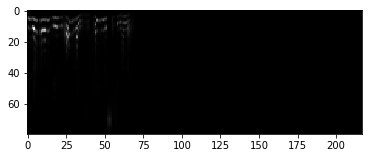

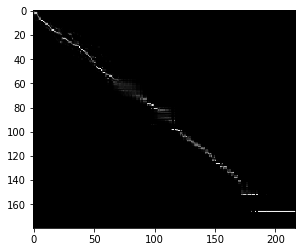

EPOCH 58


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 60 total 0.030186439021977027 mel 0.04470911994576454 att 8.950546180130914e-05
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 60, LOSS 0.030186439021977027, BEST LOSS 0.030186439021977027 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


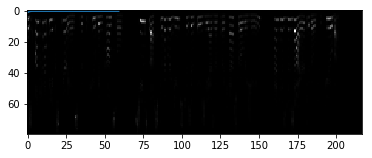

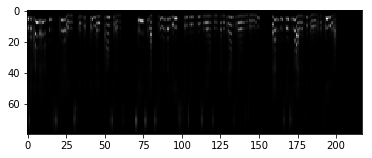

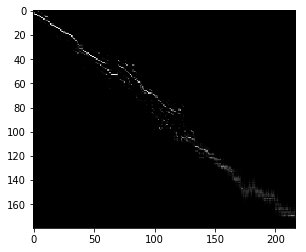

EPOCH 61



epoch 61 total 0.030096077913446213 mel 0.0443863719701767 att 0.00012490994413383305
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 61, LOSS 0.030096077913446213, BEST LOSS 0.030096077913446213 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


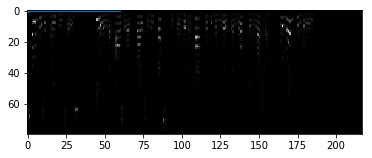

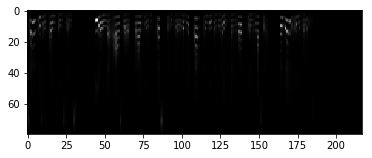

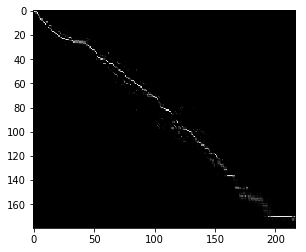

EPOCH 62



epoch 62 total 0.029981337715663126 mel 0.028280282393097878 att 0.00010774408292490989
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 62, LOSS 0.029981337715663126, BEST LOSS 0.029981337715663126 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


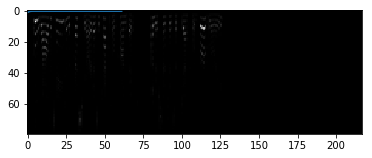

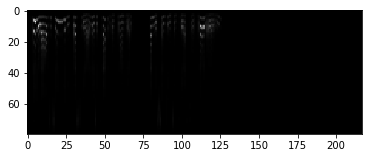

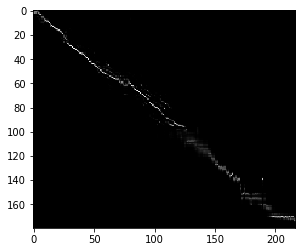

EPOCH 63


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
startEpoch = len(lossHist)
train = 1
for epoch in range(startEpoch,100*train):
    print("EPOCH",epoch)
    epochLoss = []
    for step,(batchL,batchS,_) in tqdm.tqdm_notebook(enumerate(text2MelLoader)):
        batchL = batchL.to(dev)
        batchS = batchS.to(dev)
        bL = ch.autograd.Variable(batchL)
        bS = ch.autograd.Variable(batchS)
        Shat,A = text2Mel(bL,bS)
        melloss = MelFun(Shat[:,:,:-params.chunk],bS[:,:,params.chunk:])
        attloss = GAttFun(A)
        loss = melloss + attloss
        epochLoss.append(loss.data.item())
        text2MelOpt.zero_grad()
        loss.backward()
        text2MelOpt.step()
#         if step > 10: break
    lossHist.append(np.mean(epochLoss))
    print('epoch',epoch,'total',lossHist[-1],
      'mel',melloss.data.item(),'att',attloss.data.item())
    if epoch % 1 == 0:
        bestLoss = min(lossHist[-1],bestLoss)
        state = {
            'epoch': epoch,
            'archparams': {'sep': params.sep, 'alpha': params.alpha},
            'modelState': text2Mel.state_dict(),
            'lossHist': lossHist,
            'bestLoss': bestLoss,
            'optimizerState': text2MelOpt.state_dict() 
        }
        utils.saveChkpt(state,model='text2Mel')
        plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(Shat[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(A[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        if len(lossHist) > 10: plt.plot(lossHist)

In [ ]:
import datasets
reload(datasets)

nWorkers = 8 if ch.cuda.is_available() else 0
ssrnLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=0),
                             batch_size=16,
                             shuffle=True,
                             num_workers=nWorkers)

ssrn = dcttsModel.SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)

ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 0
if load:
    startEpoch,lossHist,bestLoss = utils.loadChkpt(ssrn,ssrnOpt,'ssrn',dev)
else:
    # COLD START - RESET SSRN
    print('COLD START')
    print('HYPERPARAMS',utils.paramDict)
    ssrn = dcttsModel.SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
    ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

In [ ]:
plt.plot(lossHist)


epoch 2 total 0.17387140542268753
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 2, LOSS 0.17387140542268753, BEST LOSS 0.17387140542268753 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


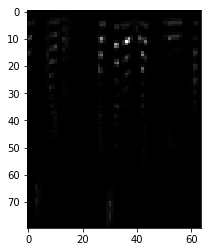

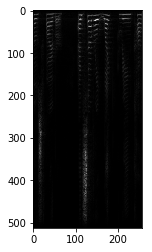

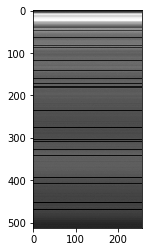

EPOCH 3



epoch 3 total 0.13230819349635892
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 3, LOSS 0.13230819349635892, BEST LOSS 0.13230819349635892 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


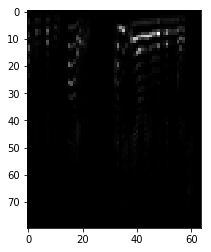

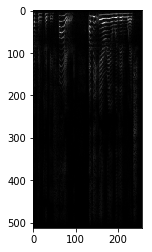

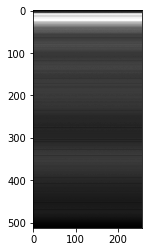

EPOCH 4



epoch 4 total 0.12716792134651497
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 4, LOSS 0.12716792134651497, BEST LOSS 0.12716792134651497 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


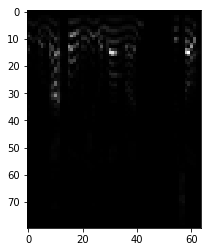

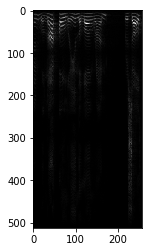

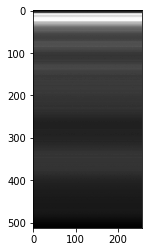

EPOCH 5



epoch 5 total 0.12713798870568846
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 5, LOSS 0.12713798870568846, BEST LOSS 0.12713798870568846 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


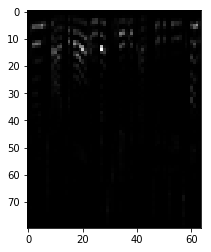

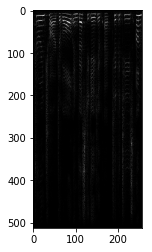

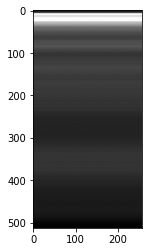

EPOCH 6



epoch 6 total 0.12705405195479963
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 6, LOSS 0.12705405195479963, BEST LOSS 0.12705405195479963 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


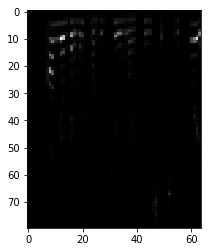

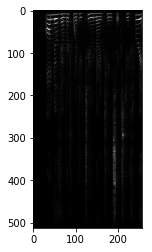

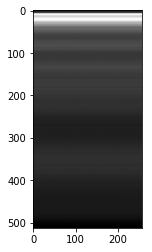

EPOCH 7



epoch 7 total 0.1273351561000098
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 7, LOSS 0.1273351561000098, BEST LOSS 0.12705405195479963 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


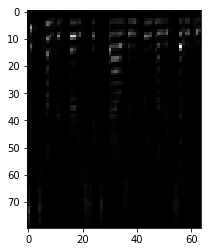

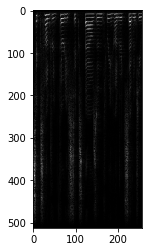

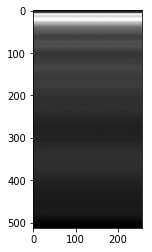

EPOCH 8



epoch 8 total 0.1272349575117453
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 8, LOSS 0.1272349575117453, BEST LOSS 0.12705405195479963 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


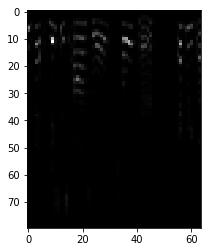

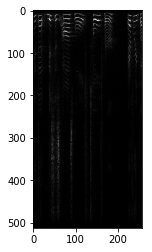

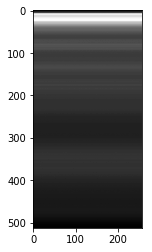

EPOCH 9



epoch 9 total 0.12729148994853248
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 9, LOSS 0.12729148994853248, BEST LOSS 0.12705405195479963 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


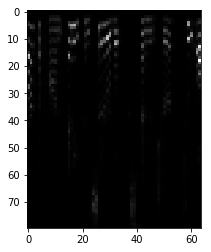

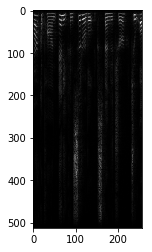

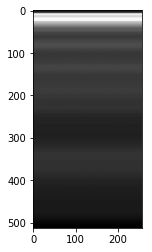

EPOCH 10



epoch 10 total 0.12701706735055837
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 10, LOSS 0.12701706735055837, BEST LOSS 0.12701706735055837 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


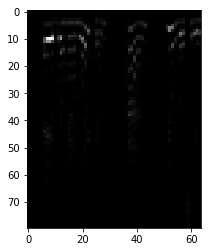

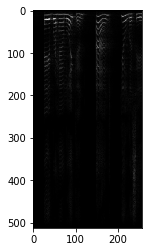

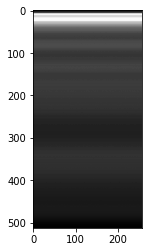

EPOCH 11



epoch 11 total 0.1271951090488861
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 11, LOSS 0.1271951090488861, BEST LOSS 0.12701706735055837 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


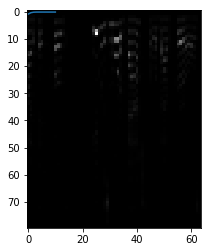

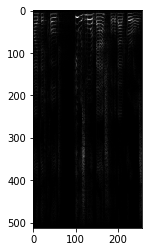

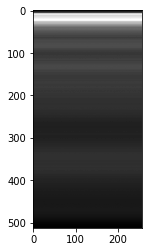

EPOCH 12



epoch 12 total 0.12722844082250523
HYPERPARAMS sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1
SAVED EPOCH 12, LOSS 0.12722844082250523, BEST LOSS 0.12701706735055837 TO ['./sep:3|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar']


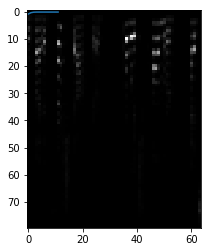

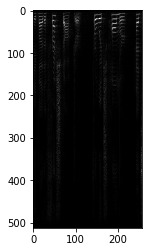

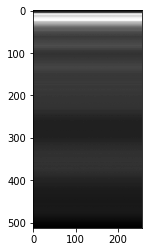

EPOCH 13


In [ ]:
startEpoch = len(lossHist)
train = 1
for epoch in range(startEpoch,30*train):
    print("EPOCH",epoch)
    epochLoss = []
    for step,(_,batchS,batchY) in tqdm.tqdm_notebook(enumerate(ssrnLoader)):
        batchS = batchS.to(dev)
        batchY = batchY.to(dev)
        bS = ch.autograd.Variable(batchS)
        bY = ch.autograd.Variable(batchY)
        Yhat = ssrn(bS)
        loss = MelFun(Yhat,bY)
        epochLoss.append(loss.data.item())
        ssrnOpt.zero_grad()
        loss.backward()
        ssrnOpt.step()
#         if step > 1: break
    lossHist.append(np.mean(epochLoss))
    bestLoss = min(bestLoss,lossHist[-1])
    print('epoch',epoch,'total',lossHist[-1])
    if epoch % 1 == 0:
        state = {
            'epoch': epoch,
            'modelState': ssrn.state_dict(),
            'lossHist': lossHist,
            'bestLoss': bestLoss,
            'optimizerState': ssrnOpt.state_dict() 
        }
        utils.saveChkpt(state,model='ssrn')
        plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(bY[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(Yhat[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        if len(lossHist) > 10: plt.plot(lossHist)